In [1]:
import plotly.express as px
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [2]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import cross_validate, cross_val_score, cross_val_predict, train_test_split

# Cleaning data

In [3]:
df_users = pd.read_hdf('data/users.h5')
df_users['nb_of_conversation_tot'] = df_users['nb_of_conversation_as_host']+df_users['nb_of_conversation_as_guest']+df_users['nb_of_conversation_for_exchange']
print(df_users.duplicated().sum())
df_subscriber = df_users[~df_users.first_subscription_date.isnull()]
df_subscriber = df_subscriber.set_index('user_id')
print(df_subscriber.isnull().sum())
df_subscriber['country']=df_subscriber['country'].fillna('unknown')
df_subscriber=df_subscriber.fillna(0)
df_subscriber['first_subscription_date'] = pd.to_datetime(df_subscriber['first_subscription_date'])
df_subscriber['last_subscription_date'] = pd.to_datetime(df_subscriber['last_subscription_date'])
df_subscriber['covid']=np.where(df_subscriber['first_subscription_date']>=pd.to_datetime('2021-04-15'), 0,1)

0
first_subscription_date                             0
last_subscription_date                              0
nb_of_inscription                                   0
mean_churn_rate                                     0
referall                                            0
promotion                                           0
country                                            83
nb_of_conversation_as_host                          0
nb_of_conversation_as_host_notFinalized             0
nb_of_exchange_as_host_done                         0
first_date_exchange_as_host_done                20315
nb_of_exchange_as_host_canceled                     0
nb_of_conversation_as_guest                      3090
nb_of_conversation_as_guest_notFinalized         3090
nb_of_exchange_as_guest_done                     3090
first_date_exchange_as_guest_done               15034
nb_of_exchange_as_guest_canceled                 3090
nb_of_conversation_for_exchange                     0
nb_of_conversation_for_exc

# Churn Prediction 

HomeExchange experiences some user churn. Several parameters were studied in the notebook : AnalysisChurn, such as the number of exchanges a user made, the use of promotions, and the number of registrations in the past three years (2019, 2020, and 2021). Since it is an annual subscription, the maximum number of subscriptions in the past three years is three.

A churner is defined as a user who decides, upon subscription renewal (after one year), whether to resubscribe or not.

Therefore, since a user can subscribe multiple times and decide to leave or not leave multiple times, the mean churn rate is calculated per user. It can be 1 (leaves after each subscription), 0 (never leaves), 0.33 (leaves once out of three subscriptions), 0.5 (leaves once out of two subscriptions), or 0.66 (leaves twice out of three subscriptions).

In this notebook, we will attempt to predict which users have the highest probability of being churners.

## First model : Logistic Regression 

The first model use is a Logistic Regression that will classify users in two categories : 
- either the user is a lost user with a mean churn rate by user of 1 (never came back)
- either the user is a lost user with a mean churn rate <1

In [4]:
df_subscriber['lost'] =  np.where(df_subscriber['mean_churn_rate']==1, 1, 0)

In [5]:
df_subscriber['lost'].value_counts()

0    45891
1    22033
Name: lost, dtype: int64

In [6]:

# same nb of user per category
dataset = df_subscriber.copy()
dataset = pd.concat([dataset[dataset['lost']==0].sample(22000),
                     dataset[dataset['lost']==1].sample(22000)])

In [7]:
features = ['covid', 
             'nb_of_inscription', 
             'promotion',
             'country',
             'nb_of_conversation_tot',
             'nb_of_exchange_as_host_done',
             'nb_of_exchange_as_guest_done',
             'nb_of_exchange_as_exchange_done']
             
target = ['lost']

In [8]:

X = dataset[features]
y = dataset[target].values
y = y.ravel()

In [9]:
X.describe()

,covid,nb_of_inscription,promotion,nb_of_conversation_tot,nb_of_exchange_as_host_done,nb_of_exchange_as_guest_done,nb_of_exchange_as_exchange_done
count,44000.000000,44000.000000,44000.000000,44000.000000,44000.000000,44000.000000,44000.000000
mean,0.911000,1.318500,0.032341,210.204000,2.147818,2.494795,0.792568
std,0.284747,0.558261,0.176906,334.174937,4.166604,4.085405,1.559591
min,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,0.000000,38.000000,0.000000,0.000000,0.000000
50%,1.000000,1.000000,0.000000,111.000000,0.000000,1.000000,0.000000
75%,1.000000,2.000000,0.000000,259.000000,3.000000,3.000000,1.000000
max,1.000000,3.000000,1.000000,16346.000000,96.000000,102.000000,30.000000


In [10]:
le = LabelEncoder()
X['country'] = le.fit_transform(X['country'])
X


/tmp/ipykernel_7539/2724099694.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['country'] = le.fit_transform(X['country'])


,covid,nb_of_inscription,promotion,country,nb_of_conversation_tot,nb_of_exchange_as_host_done,nb_of_exchange_as_guest_done,nb_of_exchange_as_exchange_done
user_id,,,,,,,,
2717588,1,1.0,0.0,51,0.0,0.0,0.0,0.0
281744,1,2.0,0.0,23,601.0,9.0,14.0,2.0
2753346,1,1.0,0.0,24,36.0,0.0,0.0,0.0
2985703,1,1.0,0.0,135,113.0,4.0,2.0,1.0
752637,1,2.0,0.0,47,202.0,3.0,9.0,0.0
...,...,...,...,...,...,...,...,...
1151208,1,1.0,0.0,47,4.0,0.0,0.0,0.0
476116,1,1.0,0.0,114,86.0,0.0,0.0,2.0
369442,1,1.0,0.0,47,33.0,0.0,0.0,0.0


In [11]:
robust = RobustScaler()
minmax = MinMaxScaler()

X[['country',
    'nb_of_conversation_tot',
   'nb_of_exchange_as_host_done',
   'nb_of_exchange_as_guest_done',
   'nb_of_exchange_as_exchange_done']] = minmax.fit_transform(X[['country','nb_of_conversation_tot',
                                                                'nb_of_exchange_as_host_done',
                                                                'nb_of_exchange_as_guest_done',
                                                                'nb_of_exchange_as_exchange_done']])
X

/tmp/ipykernel_7539/2617787385.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[['country',


,covid,nb_of_inscription,promotion,country,nb_of_conversation_tot,nb_of_exchange_as_host_done,nb_of_exchange_as_guest_done,nb_of_exchange_as_exchange_done
user_id,,,,,,,,
2717588,1,1.0,0.0,0.356643,0.000000,0.000000,0.000000,0.000000
281744,1,2.0,0.0,0.160839,0.036767,0.093750,0.137255,0.066667
2753346,1,1.0,0.0,0.167832,0.002202,0.000000,0.000000,0.000000
2985703,1,1.0,0.0,0.944056,0.006913,0.041667,0.019608,0.033333
752637,1,2.0,0.0,0.328671,0.012358,0.031250,0.088235,0.000000
...,...,...,...,...,...,...,...,...
1151208,1,1.0,0.0,0.328671,0.000245,0.000000,0.000000,0.000000
476116,1,1.0,0.0,0.797203,0.005261,0.000000,0.000000,0.066667
369442,1,1.0,0.0,0.328671,0.002019,0.000000,0.000000,0.000000


In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# store users_ids for after
test_users_ids = X_test.index

In [13]:
from sklearn.linear_model import LogisticRegression

# train model
clf = LogisticRegression()
clf.fit(X_train, y_train)

LogisticRegression()

In [14]:
# store predictions
y_pred = clf.predict(X_test)

In [15]:
print('Accuracy on train sample',round(clf.score(X_train, y_train.astype("int"))*100,2), '%')
print('Accuracy on test sample',round(clf.score(X_test, y_test.astype("int"))*100,2), '%')


Accuracy on train sample 74.04 %
Accuracy on test sample 73.64 %


In [16]:
cross_val_score(clf, X, y, scoring='accuracy', cv=5, ).mean()

0.739840909090909

Logistic regression score corresponds to accuracy.

We see here 73% accuracy on both train and test data. It means that 73% of our predictions are good.

There is no overfitting as there is no difference in scores between train and test

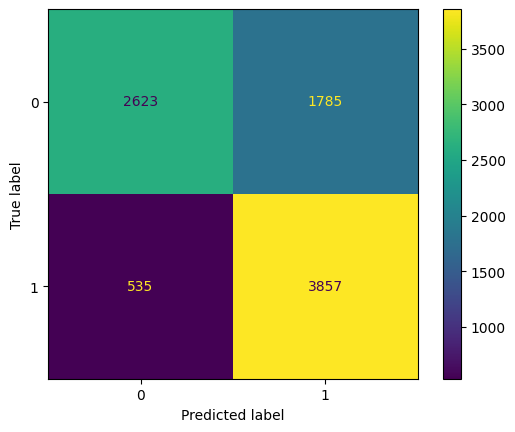

In [17]:
from sklearn.metrics import ConfusionMatrixDisplay

confusion_matrix = ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test.astype("int"))

In [18]:
print('precision',
      round(confusion_matrix.confusion_matrix[1][1]/(confusion_matrix.confusion_matrix[1][1]+confusion_matrix.confusion_matrix[1][0])*100,2),
      '%')
print('recall',
      round(confusion_matrix.confusion_matrix[1][1]/(confusion_matrix.confusion_matrix[1][1]+confusion_matrix.confusion_matrix[0][1])*100,2),
      '%')

precision 87.82 %
recall 68.36 %


In [19]:
proba = pd.DataFrame(clf.predict_proba(X_test),  columns=["notlost","lost"],index=test_users_ids)
proba

,notlost,lost
user_id,,
2637457,0.762688,0.237312
3107324,0.765608,0.234392
2387270,0.836033,0.163967
134354,0.771565,0.228435
583384,0.263724,0.736276
...,...,...
3640846,0.418232,0.581768
2061540,0.381592,0.618408
1356789,0.847894,0.152106


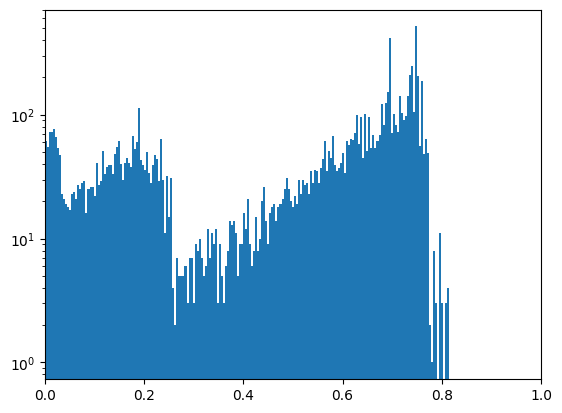

In [20]:
plt.hist(proba.lost, bins=200)

plt.xlim(0,1)
plt.yscale('log')
plt.show()

##  KNN 

### On same dataset as Logistic Regression (either lost or not lost) 



In [21]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=40)

In [22]:

knn.fit(X_train,y_train)
print(knn.score(X_train,y_train))
print(knn.score(X_test, y_test))

0.7589488636363636
0.7455681818181819


In [23]:
cross_val_score(knn, X, y, scoring='accuracy', cv=5, ).mean()

0.7397727272727274

In [24]:

proba = pd.DataFrame(knn.predict_proba(X_test),  columns=["notlost","lost"],index=test_users_ids)
proba


,notlost,lost
user_id,,
2637457,0.600,0.400
3107324,0.450,0.550
2387270,0.975,0.025
134354,0.800,0.200
583384,0.325,0.675
...,...,...
3640846,0.300,0.700
2061540,0.625,0.375
1356789,0.975,0.025


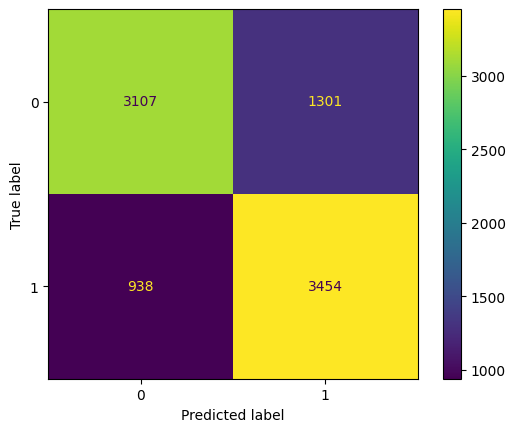

In [25]:

confusion_matrix = ConfusionMatrixDisplay.from_estimator(knn, X_test, y_test.astype("int"))

In [26]:
print('precision',
      round(confusion_matrix.confusion_matrix[1][1]/(confusion_matrix.confusion_matrix[1][1]+confusion_matrix.confusion_matrix[1][0])*100,2),
      '%')
print('recall',
      round(confusion_matrix.confusion_matrix[1][1]/(confusion_matrix.confusion_matrix[1][1]+confusion_matrix.confusion_matrix[0][1])*100,2),
      '%')

precision 78.64 %
recall 72.64 %


### On dataset with user split into 3 categories : 

- Never Stay => mean churn rate = 1
- Never Leave => mean churn rate  = 0 
- Not always leave => 0 < mean churn rate <1

In [27]:
df_subscriber['status'] =  np.where(df_subscriber['mean_churn_rate']==1, 1, 
                                    np.where(df_subscriber['mean_churn_rate']==0,0,2))
df_subscriber['status'].value_counts()

0    38126
1    22033
2     7765
Name: status, dtype: int64

In [28]:

# same nb of user per category
dataset = df_subscriber.copy()
dataset = pd.concat([dataset[dataset['status']==0].sample(7000),
                     dataset[dataset['status']==2].sample(7000),
                     dataset[dataset['status']==1].sample(7000)])
features = ['covid', 
             'nb_of_inscription', 
             'promotion',
            'referall',
             'country',
             'nb_of_conversation_tot',
             'nb_of_exchange_as_host_done',
             'nb_of_exchange_as_guest_done',
             'nb_of_exchange_as_exchange_done']
             
target = ['status']
X = dataset[features]
y = dataset[target].values
y = y.ravel()

In [29]:
le = LabelEncoder()
X['country'] = le.fit_transform(X['country'])
X
robust = RobustScaler()
minmax = MinMaxScaler()

X[['country',
    'nb_of_conversation_tot',
   'nb_of_exchange_as_host_done',
   'nb_of_exchange_as_guest_done',
   'nb_of_exchange_as_exchange_done']] = minmax.fit_transform(X[['country','nb_of_conversation_tot',
                                                                'nb_of_exchange_as_host_done',
                                                                'nb_of_exchange_as_guest_done',
                                                                'nb_of_exchange_as_exchange_done']])
X

/tmp/ipykernel_7539/2944862407.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['country'] = le.fit_transform(X['country'])
/tmp/ipykernel_7539/2944862407.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[['country',


,covid,nb_of_inscription,promotion,referall,country,nb_of_conversation_tot,nb_of_exchange_as_host_done,nb_of_exchange_as_guest_done,nb_of_exchange_as_exchange_done
user_id,,,,,,,,,
3198723,1,2.0,0.0,0.0,0.705426,0.014625,0.114583,0.0250,0.000000
1707063,1,1.0,0.0,0.0,0.449612,0.010786,0.000000,0.0000,0.000000
496041,1,1.0,0.0,0.0,0.348837,0.135832,0.020833,0.0625,0.054054
2925286,1,2.0,0.0,0.0,0.046512,0.008775,0.031250,0.0125,0.054054
495907,1,1.0,0.0,0.0,0.348837,0.276234,0.031250,0.0250,0.000000
...,...,...,...,...,...,...,...,...,...
618665,1,1.0,0.0,1.0,0.348837,0.010969,0.000000,0.0000,0.027027
340162,0,1.0,0.0,0.0,0.348837,0.098720,0.010417,0.0000,0.027027
439701,0,1.0,0.0,0.0,0.348837,0.019196,0.041667,0.0875,0.000000


In [30]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# store users_ids for after
test_users_ids = X_test.index

In [31]:
knn = KNeighborsClassifier(n_neighbors=40)
knn.fit(X_train,y_train)
print(knn.score(X_train,y_train))
print(knn.score(X_test, y_test))

0.6931547619047619
0.694047619047619


In [32]:
cross_val_score(knn, X, y, scoring='accuracy', cv=5, ).mean()

0.6797142857142857

In [33]:

proba = pd.DataFrame(knn.predict_proba(X_test),columns=['Never Stay','Never Leave','Not always Leave'],
                     index=test_users_ids)
proba

,Never Stay,Never Leave,Not always Leave
user_id,,,
2865549,0.200,0.000,0.800
767109,0.075,0.050,0.875
396988,0.325,0.675,0.000
760392,0.650,0.350,0.000
2923655,0.225,0.000,0.775
...,...,...,...
2807030,0.250,0.000,0.750
2672914,0.250,0.000,0.750
3747298,0.425,0.575,0.000


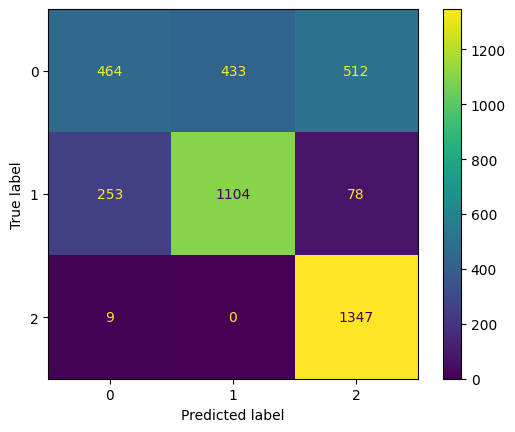

In [34]:
confusion_matrix = ConfusionMatrixDisplay.from_estimator(knn, X_test, y_test.astype("int"))    

In [35]:
df_subscriber[df_subscriber.index ==513858]

,first_subscription_date,last_subscription_date,nb_of_inscription,mean_churn_rate,referall,promotion,country,nb_of_conversation_as_host,nb_of_conversation_as_host_notFinalized,nb_of_exchange_as_host_done,...,nb_of_conversation_for_exchange,nb_of_conversation_for_exchange_notFinalized,nb_of_exchange_as_exchange_done,first_date_exchange_as_exchange_done,nb_of_exchange_as_exchange_canceled,first_date_exchange,nb_of_conversation_tot,covid,lost,status
user_id,,,,,,,,,,,,,,,,,,,,,
513858,2018-05-23,2021-07-22,2.0,0.5,0.0,0.0,FRA,703.0,703.0,0.0,...,382.0,381.0,1.0,2020-10-31 19:34:50+00:00,0.0,2020-10-31 15:35:04+00:00,1085.0,1,0,2


# TEST PYCARET

In [36]:
dataset = df_subscriber.copy()


In [45]:
dataset = dataset[['covid', 
                 'nb_of_inscription', 
                 'promotion',
                 'country',
                 'nb_of_conversation_tot',
                 'nb_of_exchange_as_host_done',
                 'nb_of_exchange_as_guest_done',
                 'nb_of_exchange_as_exchange_done','status']]
             

In [46]:
dataset['status'].value_counts()

0    7000
2    7000
1    7000
Name: status, dtype: int64

In [47]:
dataset = pd.concat([dataset[dataset['status']==0].sample(7000),
                     dataset[dataset['status']==2].sample(7000),
                     dataset[dataset['status']==1].sample(7000)])

In [48]:

from pycaret.classification import setup
exp = setup(data=dataset, target ='status', normalize=True, fold=6, session_id=42)

,Description,Value
0,Session id,42
1,Target,status
2,Target type,Multiclass
3,Original data shape,"(21000, 9)"
4,Transformed data shape,"(21000, 9)"
5,Transformed train set shape,"(14699, 9)"
6,Transformed test set shape,"(6301, 9)"
7,Numeric features,7
8,Categorical features,1
9,Preprocess,True


In [49]:
from pycaret.classification import compare_models
best =  exp.compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.6876,0.8292,0.6876,0.6752,0.6580,0.5314,0.5498,1.2367
lightgbm,Light Gradient Boosting Machine,0.6774,0.8201,0.6774,0.6606,0.6527,0.5161,0.5290,0.3317
lr,Logistic Regression,0.6757,0.8048,0.6757,0.6627,0.6265,0.5135,0.5429,0.1250
xgboost,Extreme Gradient Boosting,0.6746,0.8149,0.6746,0.6575,0.6519,0.5119,0.5231,0.8917
svm,SVM - Linear Kernel,0.6677,0.0000,0.6677,0.6641,0.6002,0.5015,0.5426,0.1333
lda,Linear Discriminant Analysis,0.6669,0.8097,0.6669,0.6550,0.6017,0.5004,0.5394,0.1267
ridge,Ridge Classifier,0.6660,0.0000,0.6660,0.6554,0.5975,0.4991,0.5401,0.1050
rf,Random Forest Classifier,0.6341,0.7979,0.6341,0.6194,0.6222,0.4511,0.4546,0.6333
knn,K Neighbors Classifier,0.6334,0.7874,0.6334,0.6180,0.6217,0.4501,0.4532,0.2200
ada,Ada Boost Classifier,0.6213,0.7761,0.6213,0.5712,0.5704,0.4319,0.4525,0.2950


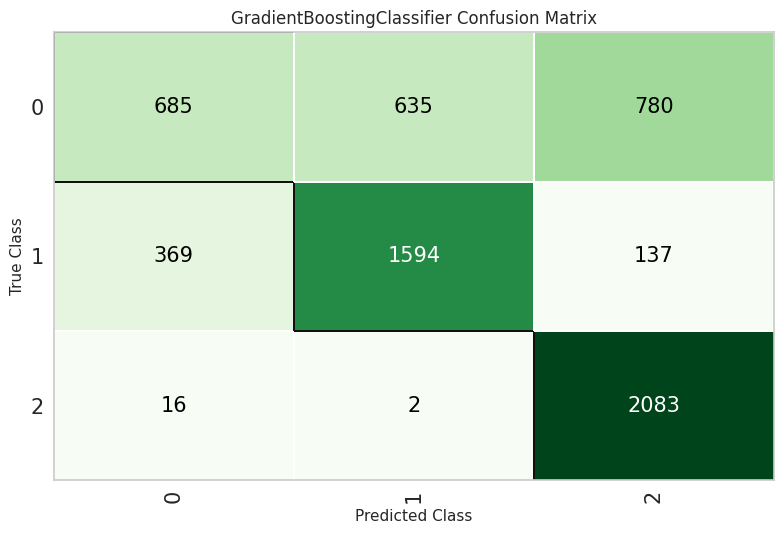

In [50]:
from pycaret.classification import plot_model
plot_model(best, plot='confusion_matrix')

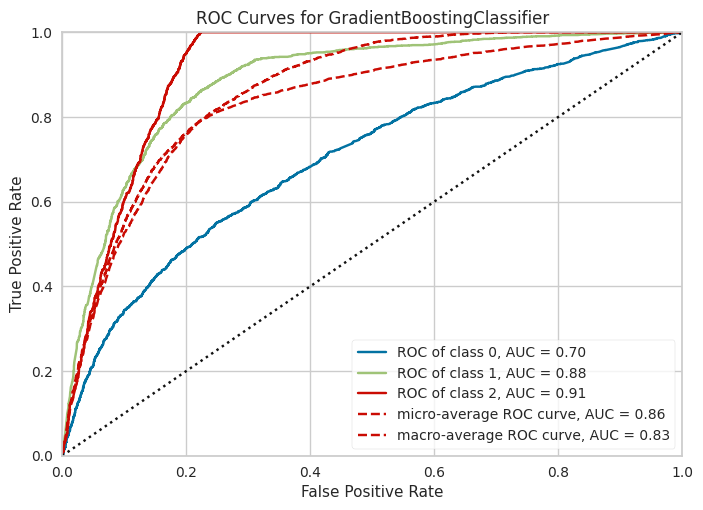

In [51]:
plot_model(best, plot='auc')

In [52]:
from pycaret.classification import tune_model

best_model_tuned = tune_model(best)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6784,0.8258,0.6784,0.6605,0.6467,0.5176,0.5357
1,0.6906,0.8233,0.6906,0.6844,0.6545,0.5359,0.5602
2,0.6833,0.8271,0.6833,0.6708,0.6490,0.5248,0.5464
3,0.7016,0.8336,0.7016,0.6921,0.6755,0.5525,0.5698
4,0.6873,0.8298,0.6873,0.6754,0.6547,0.5311,0.5522
5,0.7019,0.8294,0.7019,0.6956,0.6726,0.5529,0.5731
Mean,0.6905,0.8282,0.6905,0.6798,0.6588,0.5358,0.5562
Std,0.0088,0.0033,0.0088,0.0122,0.0111,0.0132,0.0130


Fitting 6 folds for each of 10 candidates, totalling 60 fits


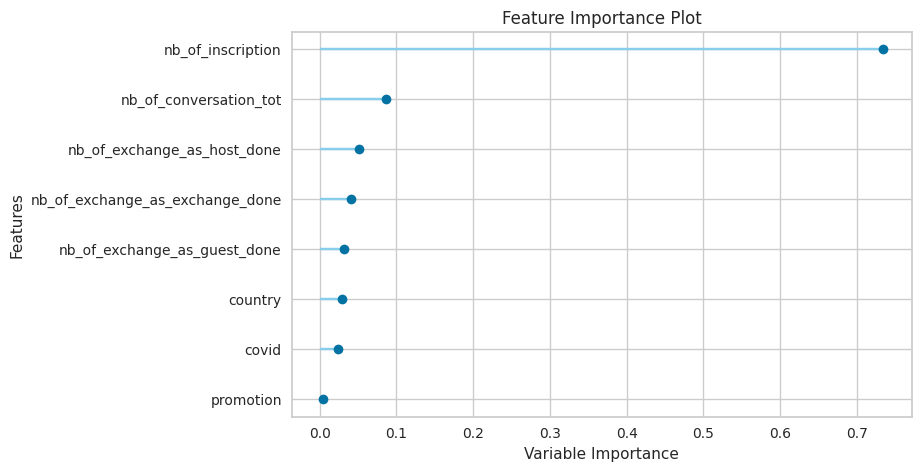

In [54]:
plot_model(best_model_tuned , plot='feature')